<a href="https://colab.research.google.com/github/AndresWV/AndresWV.github.io/blob/main/ProyectoWisdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Librerias usadas**

In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

## **1) Obtain**


1.1 Abrir el archivo




In [3]:
wisdmHarFile = open('WISDM_ar_v1.1_raw.txt')

1.2 df con los datos



In [4]:

#wisdmHarDf = pd.DataFrame(data = wisdmHarFile) 
#wisdmHarDf.head()

## **Entrega 02 - SCRUB**



Eliminar filas con datos faltantes


Tomar lineas

In [5]:
readLiness = wisdmHarFile.readlines()

Crear Df con los datos limpios, indicando las lineas con datos faltantes(print en el mismo formato solicitado)

In [6]:
wisdmHarDf = []

for nLine,line in enumerate(readLiness):
    try:
        #Separar los datos para extraer valores de las col
        line = line.split(',')
        #Quitar punto y coma del final
        lineStrip = line[5].split(';')[0]
        #Quitar saltos espacios de inicio y fin
        lineStrip = lineStrip.strip()
        #Si queda vacio salta a la excepción para que no se agregue al df
        if lineStrip == '':
            break;
        col = [line[0], line[1], line[2], line[3], line[4], lineStrip]
        #agregar col limpia
        wisdmHarDf.append(col)
    except:
        print('Error at line number: ', nLine)

Error at line number:  260058


Agregar al DataFrame los nombres de las columnas

In [7]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
wisdmHarDf2 = pd.DataFrame(data = wisdmHarDf, columns = columns)



Visualizar las 5 primeras filas del DataFrame (.head())


In [8]:
wisdmHarDf2.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


Buscar datos nulos y eliminarlos si es que existen

In [9]:
#Contar los datos vacios, si existen, dropeo de nuevo
nVacios = wisdmHarDf2.isnull().sum().sum()
if nVacios>0:
  wisdmHarDf2 = wisdmHarDf2.dropna()
else:
  print("No hay datos nulos!") 


No hay datos nulos!


Visualizar los tipo de datos a los que pertenece cada columna (.info())

In [10]:
wisdmHarDf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260058 entries, 0 to 260057
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      260058 non-null  object
 1   activity  260058 non-null  object
 2   time      260058 non-null  object
 3   x         260058 non-null  object
 4   y         260058 non-null  object
 5   z         260058 non-null  object
dtypes: object(6)
memory usage: 11.9+ MB


Cambiar el tipo de datos de las variables predictoras a valores reales, para realizar la clasificación

In [11]:
wisdmHarDf2 = wisdmHarDf2.astype({'x':'float','y':'float','z':'float'})

Imprimir los tipos de datos de las variables del DataFrame

In [12]:
wisdmHarDf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260058 entries, 0 to 260057
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      260058 non-null  object 
 1   activity  260058 non-null  object 
 2   time      260058 non-null  object 
 3   x         260058 non-null  float64
 4   y         260058 non-null  float64
 5   z         260058 non-null  float64
dtypes: float64(3), object(3)
memory usage: 11.9+ MB


Eliminar las columnas que no se utilizaran para la clasificación

In [13]:
#Generar un nuevo df sin user ni time
wisdmHarDf3 = wisdmHarDf2.drop(['user', 'time'], axis=1)
#Ver que se hayan eliminado correctamente las col que nos se usaran
wisdmHarDf3.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


Utilizar el comando value_counts para obtener un detalle de cuantas instancias se tienen por actividad. El objetivo consiste en identificar la presencia del balance o desbalance en las categorías a modelar

In [14]:
wisdmHarDf3.value_counts('activity')

activity
Walking       99080
Jogging       95326
Upstairs      28898
Downstairs    28600
Sitting        4599
Standing       3555
dtype: int64

Este proyecto considera datos con un desbalance de clases. Es necesario balancearlos para que los modelos operen de manera adecuada. Existen muchas maneras de realizar un balance, pero en este proyecto utilizaremos una estrategia sencilla e intuitiva. Simplemente debe identificar la actividad que contenga el número menor de instancias. Se debe realizar un muestreo para las otras actividades utilizando ese valor. De esta manera todas las clases tendrán la misma cantidad de instancias.

In [15]:
#Balancear en torno a Stading que es el menor(3555)
Walking = wisdmHarDf3[wisdmHarDf3['activity']=='Walking'].head(3555).copy()
Jogging = wisdmHarDf3[wisdmHarDf3['activity']=='Jogging'].head(3555).copy()
Upstairs = wisdmHarDf3[wisdmHarDf3['activity']=='Upstairs'].head(3555).copy()
Downstairs = wisdmHarDf3[wisdmHarDf3['activity']=='Downstairs'].head(3555).copy()
Sitting = wisdmHarDf3[wisdmHarDf3['activity']=='Sitting'].head(3555).copy()
Standing = wisdmHarDf3[wisdmHarDf3['activity']=='Standing'].copy()
#nuevo df para el df balanceado 
wisdmHarDf4 = pd.DataFrame()
wisdmHarDf4 = wisdmHarDf4.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])


Establecer el número de instancias y dimensiones del data frame resultante (shape)

In [16]:
wisdmHarDf4.shape

(21330, 4)

Volver a imprimir la cantidad de instancias por categoría para verificar que todo esté en orden. (value_counts)

In [17]:
wisdmHarDf4.value_counts('activity')

activity
Downstairs    3555
Jogging       3555
Sitting       3555
Standing      3555
Upstairs      3555
Walking       3555
dtype: int64

Volver a visualizar las cinco primeras líneas del DataFrame para revisar que todo esté en orden (head)

In [18]:
wisdmHarDf4.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


Separar las variables predictoras (X) de las ctegorias o etiquetas (y)

In [19]:
#Ajuste el codificador de etiquetas(Y) y devuelva las etiquetas codificadas.
wisdmHarDf4['label'] = LabelEncoder().fit_transform(wisdmHarDf4['activity'])
X = wisdmHarDf4[['x', 'y', 'z']]
y = wisdmHarDf4['label']


Estandarizar los datos numericos (StandardScaler)

In [20]:
#Ajuste a los datos codificados para transformarlos. 
X = StandardScaler().fit_transform(X)
scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X

,x,y,z
0,0.000503,-0.099190,0.337933
1,0.073590,0.020386,0.633446
2,-0.361275,1.588160,-0.103312
3,1.060258,0.437573,-0.844119
4,-0.237028,0.139962,-0.698386
...,...,...,...
21325,-0.470217,0.178084,0.261019
21326,-0.542658,0.193692,0.248875
21327,-0.628514,0.197593,0.261019
21328,-0.781444,0.049322,0.155768


## **Explore**

Diagrama de actividad vs tiempo(Para mirar el balanceo)

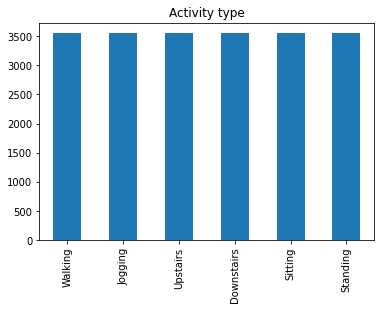

In [38]:
actividadesTiempo = wisdmHarDf4['activity'].value_counts().plot(kind='bar', title='Activity type')


Grafico para mostrar como el nivel de aceleración se va cambiando con el paso del tiempo, con estos graficos podemos concluir cual actividad fisica demanda una mayor resistencia cardiovascular, tan solo evaluando los niveles maximos de aceleración que estas tienen. Haciendo las comparativas con otros graficos, por ejemplo de jogging vs walking, podemos observar que jogging tiene mayores niveles de aceleración y seria normal asumir este resultado, debido a que uno al trotar tiene un ritmo más rapido que al caminar. Se puede aplicar esta misma logica con las demás actividades para tener este tipo de conclusiones.

Text(0, 0.5, 'X acceleration (dg)')

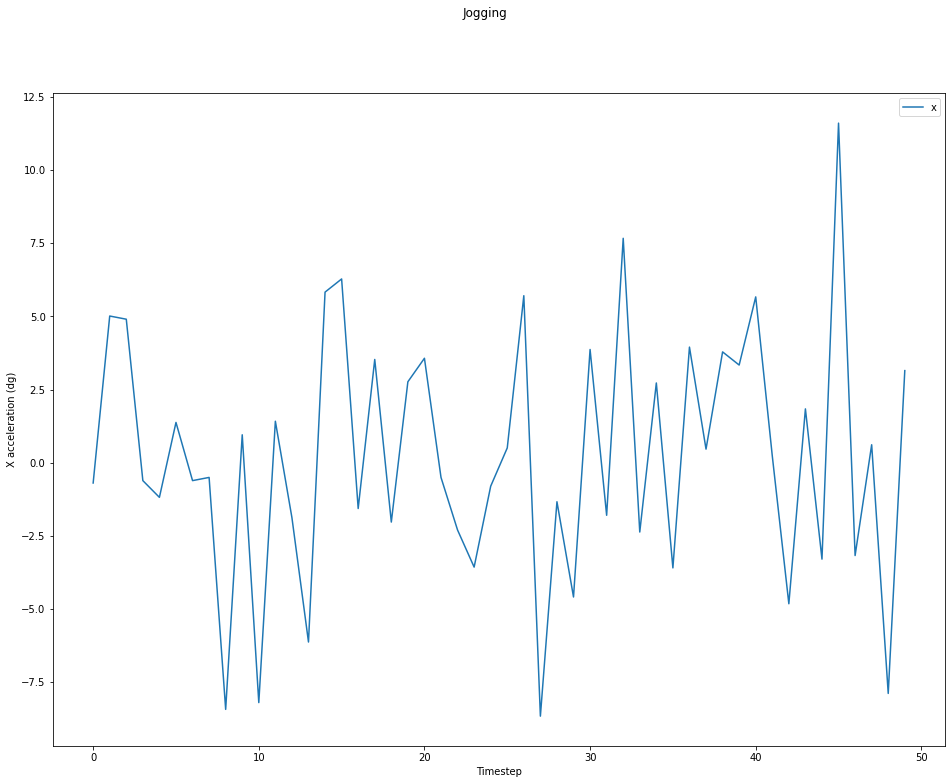

In [39]:
wisdmHarDf4[wisdmHarDf4['activity'] == 'Jogging'][['x']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')

Text(0, 0.5, 'X acceleration (dg)')

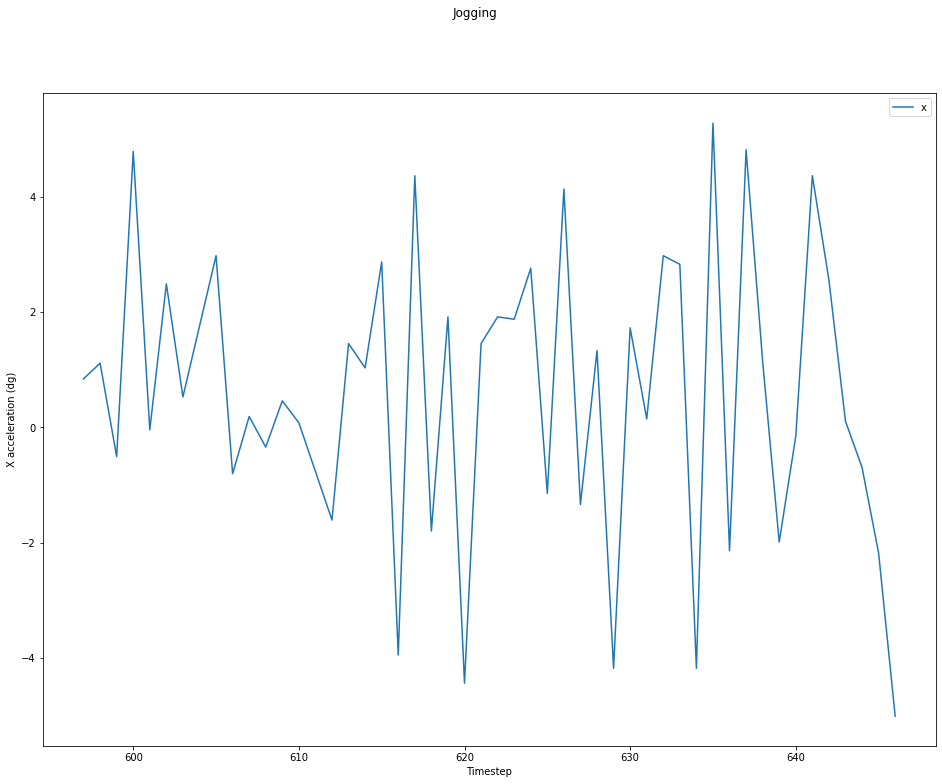

In [40]:
wisdmHarDf4[wisdmHarDf4['activity'] == 'Walking'][['x']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')